<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/XY4%20XY8%20XY16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [1]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 20.9 MB/s eta 0:00:00


In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

# Coherent Photon Drive

## Simulation Parameter Setting & Hamiltonian

Lab Frame

$H_0 = -\frac{\omega_q}{2}\sigma_z + \omega_r a^\dagger a + \omega_f b^\dagger b + g(\sigma_+a+\sigma_-a^\dagger) + G(a^\dagger b + a b^\dagger)$

$H_1 = A(t) (\hat{a} + \hat{a}^\dagger) \cos{(\omega_{rd} t)}$

$H_2 = B(t) \sigma_x \cos{(\omega_{qd} t)}$

In [41]:
# single pi & half pi square pulse for drive

def Pi_Square(t, args, T_cent):

    A = args['A']

    return A * (t > T_cent-0.5*np.pi/A) * (t < T_cent+0.5*np.pi/A)


def Half_Pi_Square(t, args, T_cent):

    A = args['A']

    return 0.5 * A * (t > T_cent-0.5*np.pi/A) * (t < T_cent+0.5*np.pi/A)

In [7]:
# time-dependent envelope for drive

def Hrd_env(Env, Is_Pi):

  if (Env==0 and Is_Pi==0):
    return Half_Pi_Square

  elif (Env==0 and Is_Pi==1):
    return Pi_Square


# time-dependent function for drive

def Hrd_rot(f, t, args, T_cent):

    Omega_rd = args['Omega_rd']
    Phi = args['Phi']

    return f(t, args, T_cent) * np.cos(Omega_rd * t + Phi)

In [8]:
# Modulate each pulse timing
# pulse list
# pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N, Func):

    T = T_end - T_srt

    Seq_list = []

    if (Func==2) :
      shift = 0
      for i in range(N):
        shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
        Seq_list.append(T_srt + shift)

    else :
      for i in range(N):
        Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq

In [16]:
# time-dependent envelope for qubit drive (rotating frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hqd_rotating_frame(t, args):

    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    Env = args['Env']
    Func = args['Func']

    B = args['B']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    f = Hrd_env(Env, 0)
    pulse = 0

    for T_cent in Seq:
      f = Hrd_env(Env, 1)
      pulse = pulse + f(t, {'A': B}, T_cent)

    return pulse


def Hqd_lab_frame(t, args):
    omega_qd = args['Omega_qd']
    phi_qd = args['Phi_qd']
    return Hqd_rotating_frame(t, args) * np.cos(omega_rd * t + phi_qd)

In [10]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

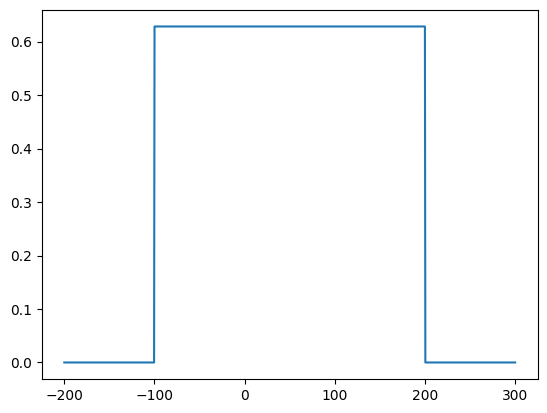

In [11]:
# resonator pulse simulation (rotating frame)
tlist = np.linspace(-200, 300, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*0.1, 'T_srt_r': -100, 'T_end_r': 200}))

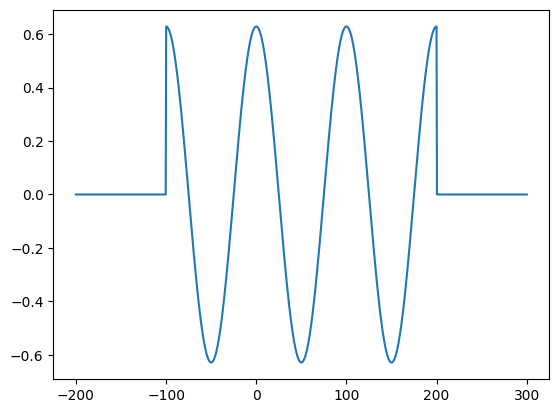

In [14]:
# resonator pulse simulation (rotating frame)
tlist = np.linspace(-200, 300, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.1, 'T_srt_r': -100, 'T_end_r': 200, 'Omega_rd': 2*np.pi*10}))

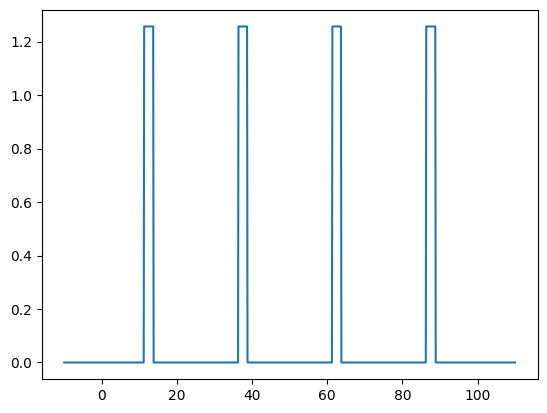

In [13]:
# qubit pulse simulation (rotating frame)
tlist = np.linspace(-10, 110, 1000)
plt.figure()
plt.plot(tlist, Hqd_rotating_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Env': 0, 'Func': 0}))

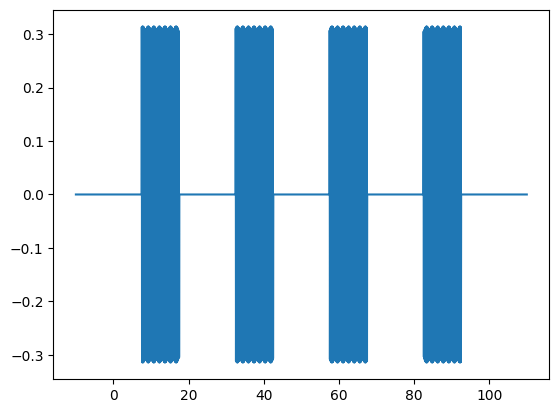

In [18]:
# qubit pulse simulation (rotating frame)
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, Hqd_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Env': 0, 'Func': 0, 'Omega_qd': 2*np.pi*10, 'Phi_qd': 0.5*np.pi}))

## Dynamical Decoupling Simulation


In [34]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_r-omega_q
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q + chi      # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]
taulist = np.array([100*(k+5) for k in range(11)])

In [35]:
zlist = []
pluslist = []

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), coherent(N, 0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

A = 0.0005 * 2 * np.pi
B = 0.05 * 2 * np.pi
N_seq = 4


# iterate for evolution time 5000ns ~ 50000ns
for k in range(11):

  # Simulation
  tlist = np.linspace(0, 1000*(k+1), 10000*(k+1))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, Hqd_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': 1000*(k+1), 'N_seq': N_seq, 'Env': 0, 'Func': 0, 'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_qd': omega_qd, 'Phi_qd': 0, 'Omega_rd': omega_rd},
    e_ops = op_list,
  )

  print(np.mean(result.expect[4]))

  z = result.expect[2]
  plus = 2*np.abs(result.expect[3])

  zlist.append(z[-1])
  pluslist.append(plus[-1])

zlist = np.array(zlist)
pluslist = np.array(pluslist)

0.005540934860151923
0.004096079638462355
0.003283134537121888
0.002882356474215811
0.0024886494682653244
0.0022220475165971253


KeyboardInterrupt: 

Text(0, 0.5, 'Decoherence')

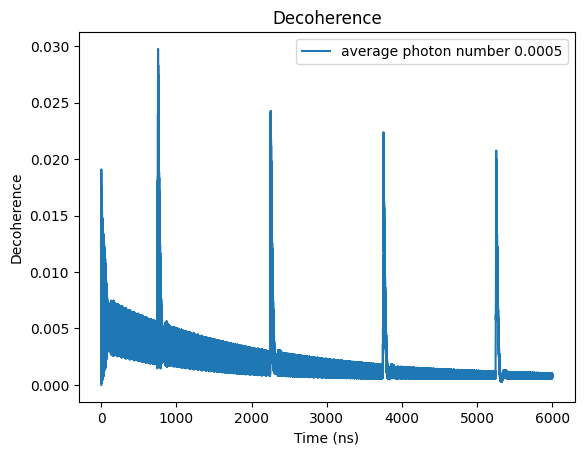

In [37]:
# Plot Results

plt.plot(tlist[:60000], result.expect[4][:60000], label = 'average photon number 0.0005')

plt.legend(loc = 0)
plt.title('Decoherence')
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Decoherence')

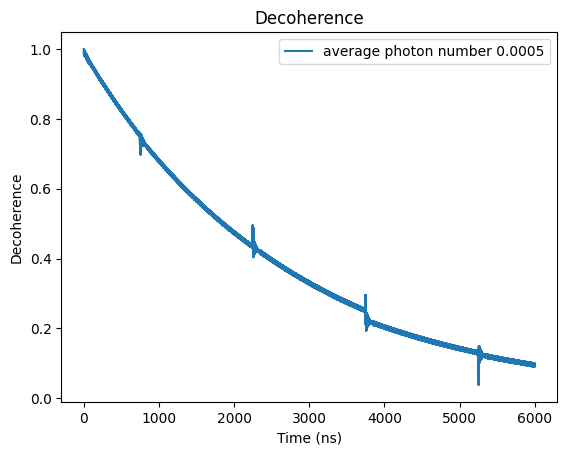

In [38]:
# Plot Results

plt.plot(tlist[:60000], 2*np.abs(result.expect[3][:60000]), label = 'average photon number 0.0005')

plt.legend(loc = 0)
plt.title('Decoherence')
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

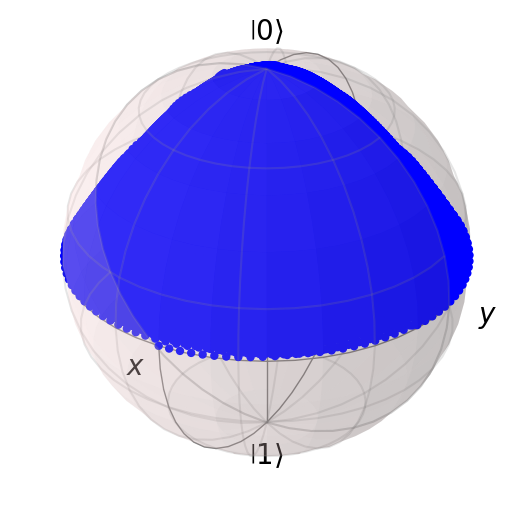

In [39]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Decoherence')

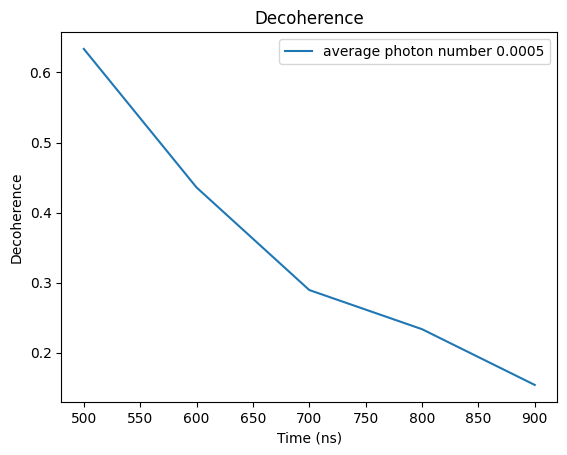

In [40]:
# Plot Results

plt.plot(taulist[0:5], pluslist[0:5], label = 'average photon number 0.0005')

plt.legend(loc = 0)
plt.title('Decoherence')
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

In [ ]:
n_coh = 0.0005

delta_t = taulist/20
gamma_phi = -np.log(pluslist)/(taulist)  #- 0.5*kappa*g**2/detune**2

"""
f_1 = 1+4*chi**2/kappa**2
f_2 = (np.cosh(kappa*delta_t/2) - np.cos(chi*delta_t))/(kappa*delta_t/4*np.sinh(kappa*delta_t/2)*f_1)
f_3 = 1 +chi/kappa*np.sin(chi*delta_t)/np.sinh(kappa*delta_t/2) - 2*(chi/kappa)**2

gamma_coh_gaussian = (8*chi**2*n_coh/kappa)*(1-np.tanh(kappa*delta_t/4)/(kappa*delta_t/4))
gamma_coh_nongaussian = (4*chi**2*n_coh/(kappa*f_1))*(1-f_2*f_3)

print(kappa*g**2/detune**2)

# Plot Results

plt.plot(delta_t, gamma_phi, label = '0.0005, simulation')
plt.plot(delta_t, gamma_coh_gaussian, label = '0.0005, gaussian theory')
plt.plot(delta_t, gamma_coh_nongaussian, label = '0.0005, non-gaussian theory')
"""
plt.plot(delta_t, gamma_phi, label = '0.0005, simulation')

plt.legend(loc = 0)
plt.title('Pure Dephasing')
plt.xlabel('Time (ns)')
plt.ylabel('Pure Dephasing Rate (kHz)')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
# Plot Results

plt.plot(taulist, pluslist, label = 'average photon number 0.0005')

plt.legend(loc = 0)
plt.title('Decoherence')
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

In [ ]:
n_coh = 0.0005

delta_t = taulist/20
gamma_phi = -np.log(pluslist)/(taulist)  #- 0.5*kappa*g**2/detune**2

"""
f_1 = 1+4*chi**2/kappa**2
f_2 = (np.cosh(kappa*delta_t/2) - np.cos(chi*delta_t))/(kappa*delta_t/4*np.sinh(kappa*delta_t/2)*f_1)
f_3 = 1 +chi/kappa*np.sin(chi*delta_t)/np.sinh(kappa*delta_t/2) - 2*(chi/kappa)**2

gamma_coh_gaussian = (8*chi**2*n_coh/kappa)*(1-np.tanh(kappa*delta_t/4)/(kappa*delta_t/4))
gamma_coh_nongaussian = (4*chi**2*n_coh/(kappa*f_1))*(1-f_2*f_3)

print(kappa*g**2/detune**2)

# Plot Results

plt.plot(delta_t, gamma_phi, label = '0.0005, simulation')
plt.plot(delta_t, gamma_coh_gaussian, label = '0.0005, gaussian theory')
plt.plot(delta_t, gamma_coh_nongaussian, label = '0.0005, non-gaussian theory')
"""
plt.plot(delta_t, gamma_phi, label = '0.0005, simulation')

plt.legend(loc = 0)
plt.title('Pure Dephasing')
plt.xlabel('Time (ns)')
plt.ylabel('Pure Dephasing Rate (kHz)')

In [ ]:
gamma_phi

In [ ]:
0.5*kappa*g**2/detune**2

In [ ]:
n_coh = 0.0005

delta_t = taulist/N_seq
gamma_phi = -np.log(pluslist)/(taulist)  #- 0.5*kappa*g**2/detune**2


f_1 = 1+4*chi**2/kappa**2
f_2 = (np.cosh(kappa*delta_t/2) - np.cos(chi*delta_t))/(kappa*delta_t/4*np.sinh(kappa*delta_t/2)*f_1)
f_3 = 1 +chi/kappa*np.sin(chi*delta_t)/np.sinh(kappa*delta_t/2) - 2*(chi/kappa)**2

gamma_coh_gaussian = (8*chi**2*n_coh/kappa)*(1-np.tanh(kappa*delta_t/4)/(kappa*delta_t/4))
gamma_coh_nongaussian = (4*chi**2*n_coh/(kappa*f_1))*(1-f_2*f_3)

print(kappa*g**2/detune**2)

# Plot Results

plt.plot(delta_t, gamma_phi, label = '0.0005, simulation')
#plt.plot(delta_t, gamma_coh_gaussian, label = '0.0005, gaussian theory')
plt.plot(delta_t, gamma_coh_nongaussian, label = '0.0005, non-gaussian theory')

plt.legend(loc = 0)
plt.title('Pure Dephasing')
plt.xlabel('Time (ns)')
plt.ylabel('Pure Dephasing Rate (kHz)')

In [ ]:
psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), coherent(N, 0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*(omega_q-omega_qd)*sz_composite + (omega_r-omega_rd)*number_composite + chi*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite


# Simulation
tlist = np.linspace(0, 100*(10+5), 1000*(10+5))

result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_21,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100*(k+5), 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 0.0032 * 2 * np.pi, 'T_srt_r': -100, 'T_end_r': 150000},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4], label = 'average photon number 0.0005')

plt.legend(loc = 0)
plt.title('Decoherence')
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2], label = 'average photon number 0.0005')

plt.legend(loc = 0)
plt.title('Decoherence')
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

# Thermal Photon Drive

## Filtering Function (μs, MHz scale)

In [ ]:
omega_list = np.linspace(0,10,10000)

def filter(omega_list, tau, N):

  if N==0:
    f = (4*np.sin(2*np.pi*tau*omega_list/2)*np.sin(2*np.pi*tau*omega_list/2))/(2*np.pi*2*np.pi*omega_list**2)
    return f

  elif N==1:
    f = ((4*np.sin(2*np.pi*tau*omega_list/4)*np.sin(2*np.pi*tau*omega_list/4))/(2*np.pi*omega_list))**2
    return f

  else:
    f = (2*np.sin(2*np.pi*tau*omega_list/2)*(np.cos(2*np.pi*tau*omega_list/(2*N))-1)/(2*np.pi*omega_list*np.cos(2*np.pi*tau*omega_list/(2*N))))**2
    return f

<ipython-input-271-09a753571ad5>:6: RuntimeWarning: invalid value encountered in divide
  f = (4*np.sin(2*np.pi*tau*omega_list/2)*np.sin(2*np.pi*tau*omega_list/2))/(2*np.pi*2*np.pi*omega_list**2)
<ipython-input-271-09a753571ad5>:10: RuntimeWarning: invalid value encountered in divide
  f = ((4*np.sin(2*np.pi*tau*omega_list/4)*np.sin(2*np.pi*tau*omega_list/4))/(2*np.pi*omega_list))**2
<ipython-input-271-09a753571ad5>:14: RuntimeWarning: invalid value encountered in divide
  f = (2*np.sin(2*np.pi*tau*omega_list/2)*(np.cos(2*np.pi*tau*omega_list/(2*N))-1)/(2*np.pi*omega_list*np.cos(2*np.pi*tau*omega_list/(2*N))))**2


Text(0, 0.5, 'Filter Function Distribution')

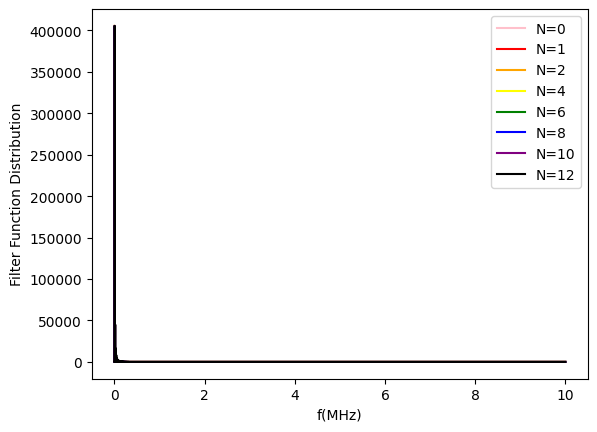

In [ ]:
tau = 1000

fig, ax = plt.subplots(1, 1)
ax.plot(omega_list, filter(omega_list, tau, 0), label = 'N=0', color='pink')
ax.plot(omega_list, filter(omega_list, tau, 1), label = 'N=1', color='red')
ax.plot(omega_list, filter(omega_list, tau, 2), label = 'N=2', color='orange')
ax.plot(omega_list, filter(omega_list, tau, 4), label = 'N=4', color='yellow')
ax.plot(omega_list, filter(omega_list, tau, 6), label = 'N=6', color='green')
ax.plot(omega_list, filter(omega_list, tau, 8), label = 'N=8', color='blue')
ax.plot(omega_list, filter(omega_list, tau, 10), label = 'N=10', color='purple')
ax.plot(omega_list, filter(omega_list, tau, 12), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('f(MHz)')
ax.set_ylabel('Filter Function Distribution')

In [ ]:
def lorentzian(omega_list, kappa, n):
  return n*kappa/((2*np.pi*omega_list)**2 + (kappa/2)**2)

In [ ]:
def chi_N(tau, kappa, n, kai, N):
  freq_list = np.linspace(0.01,10000.01,1000000)
  filt = filter(freq_list, tau, N)
  spec = lorentzian(freq_list, kappa, n)
  A = 0
  for i in range(10000):
    A = A + 2*np.pi * 2*kai**2 * filt[i]*spec[i]*0.01

  return A

ValueError: x and y must have same first dimension, but have shapes (100000,) and (100,)

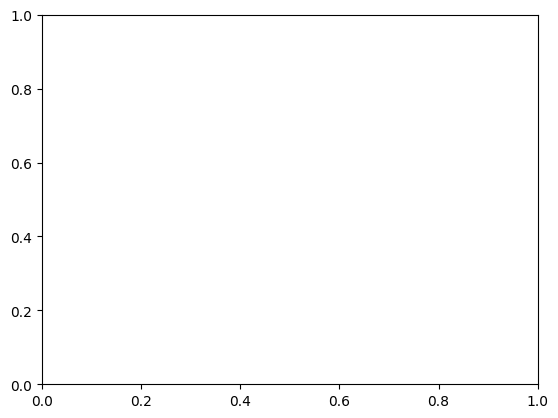

In [ ]:
# MHz Scale

tau_list = np.linspace(0,1000,100000)

kappa = 2*np.pi*10
n = 0.0001
kai = 2*np.pi*10


fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 2) for tau in range(100)]), label = 'N=2', color='orange')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_white(t)')

Text(0, 0.5, 'chi_white(t)')

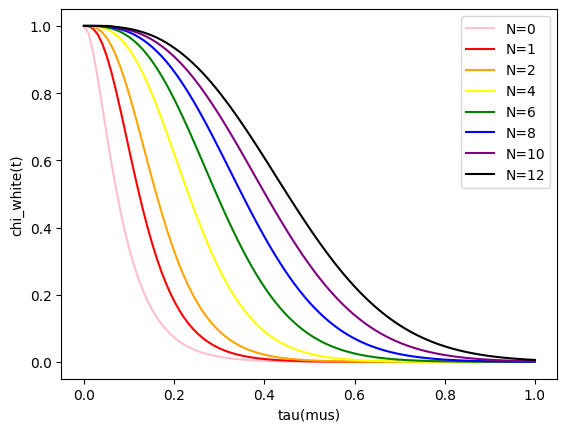

In [ ]:
# MHz Scale

tau_list = np.linspace(0,1,100)

kappa = 2*np.pi*10
n = 0.01
kai = 2*np.pi*10


fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 0) for tau in range(100)])), label = 'N=0', color='pink')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 1) for tau in range(100)])), label = 'N=1', color='red')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 2) for tau in range(100)])), label = 'N=2', color='orange')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 4) for tau in range(100)])), label = 'N=4', color='yellow')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 6) for tau in range(100)])), label = 'N=6', color='green')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 8) for tau in range(100)])), label = 'N=8', color='blue')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 10) for tau in range(100)])), label = 'N=10', color='purple')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 12) for tau in range(100)])), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_white(t)')

## Simulation Parameter Setting & Hamiltonian

Lab Frame

$H_0 = -\frac{\omega_q}{2}\sigma_z + \omega_r a^\dagger a + g\sigma_x(a+a^\dagger)$

$H_2 = B(t) \sigma_x \cos{(\omega_{qd} t)}$

Rotating Frame

$H_0 = -\frac{\omega_q-\omega_{qd}}{2}\sigma_z + (\omega_r)a^\dagger a + \chi\sigma_z(a^\dagger a)$

$H_2 = \frac{B(t)}{2}  \sigma_x $

$ 2 \chi/\kappa = 2 $

CPMG $\pi$ Pulse $N=4$

In [ ]:
# operator
N = 5

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

chi = 2 * np.pi * 0.01

In [ ]:
sz = sigmaz()
sx = sigmax()
sy = sigmay()

sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)

In [ ]:
sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

In [ ]:
H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())

H1 = 0.5*tensor(qeye(2), a + a.dag())

H2_x = 0.5*sx_composite

In [ ]:
# single pi & half pi square pulse for drive

def Pi_Square(t, args, T_cent):

    A = args['A']

    return A * (t > T_cent-0.5*np.pi/A) * (t < T_cent+0.5*np.pi/A)

def Half_Pi_Square(t, args, T_cent):

    A = args['A']

    return 0.5 * A * (t > T_cent-0.5*np.pi/A) * (t < T_cent+0.5*np.pi/A)

In [ ]:
# time-dependent envelope for drive

def Hrd_env(Env, Is_Pi):

  if (Env==0 and Is_Pi==0):
    return Half_Pi_Square

  elif (Env==0 and Is_Pi==1):
    return Pi_Square

# time-dependent function for drive

def Hrd_rot(f, t, args, T_cent):

    Omega_rd = args['Omega_rd']
    Phi = args['Phi']

    return f(t, args, T_cent) * np.cos(Omega_rd * t + Phi)

In [ ]:
# Modulate each pulse timing
# pulse list
# pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N, Func):

    T = T_end - T_srt

    Seq_list = []

    if (Func==2) :
      shift = 0
      for i in range(N):
        shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
        Seq_list.append(T_srt + shift)

    else :
      for i in range(N):
        Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq

In [ ]:
# time-dependent envelope for qubit drive (rotating frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hqd_rotating_frame(t, args):

    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    Env = args['Env']
    Func = args['Func']

    B = args['B']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    f = Hrd_env(Env, 0)
    pulse = f(t, {'A': B}, T_srt)

    for T_cent in Seq:
      f = Hrd_env(Env, 1)
      pulse = pulse + f(t, {'A': B}, T_cent)

    f = Hrd_env(Env, 0)
    pulse = pulse + f(t, {'A': B}, T_end)

    return pulse

In [ ]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)

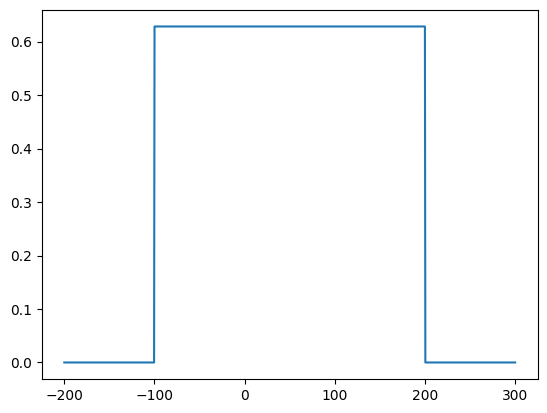

In [ ]:
# resonator pulse simulation (rotating frame)
tlist = np.linspace(-200, 300, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*0.1, 'T_srt_r': -100, 'T_end_r': 200}))

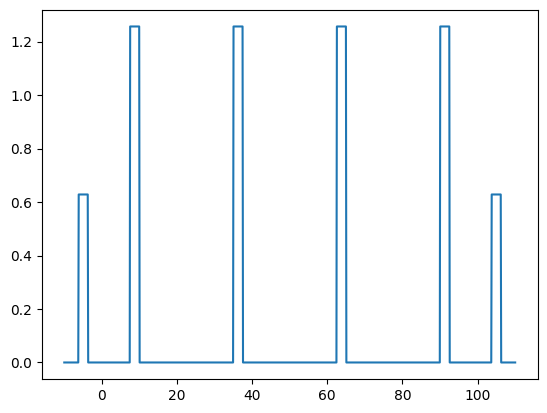

In [ ]:
# qubit pulse simulation (rotating frame)
tlist = np.linspace(-10, 110, 1000)
plt.figure()
plt.plot(tlist, Hqd_rotating_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': -5, 'T_end_q': 105, 'N_seq': 4, 'Env': 0, 'Func': 0}))

## Dynamical Decoupling Simulation


In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01

detune = omega_r-omega_q
chi = g*g/(detune)

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]
taulist = np.array([1000*(k+5) for k in range(11)])

In [ ]:
A = 0.001 * 2 * np.pi
N_seq = 20

n_th = 0.0005

zlist = []
pluslist = []

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = omega_r*number_composite + chi*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

# iterate for evolution time 100ns ~ 1000ns
for k in range(11):

  # Simulation
  tlist = np.linspace(0, 1000*(k+5), 10000*(k+5))

  result = mesolve(
    [H0, [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa*(n_th+1)) * tensor(qeye(2), a), np.sqrt(kappa*(n_th)) * tensor(qeye(2), a.dag())],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -20, 'T_end_q': 1000*(k+5)+20, 'N_seq': N_seq, 'Env': 0, 'Func': 0, 'A': A, 'T_srt_r': -100, 'T_end_r': 1500000},
    e_ops = op_list,
    options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
  )

  print(np.mean(result.expect[4]))

  z = result.expect[2]
  plus = 2*np.abs(result.expect[3])

  zlist.append(z[-1])
  pluslist.append(plus[-1])

zlist = np.array(zlist)
pluslist = np.array(pluslist)

/usr/local/lib/python3.10/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


0.0004984034770069448
0.0004986695597514875
0.000498859619937433
0.0004990021656689469
0.0004991130349221149
0.0004992017305456966
0.0004992742998384108
0.0004993347743494821
0.0004993859451609635
0.0004994298059085711
0.0004994678185953632


Text(0, 0.5, 'Decoherence')

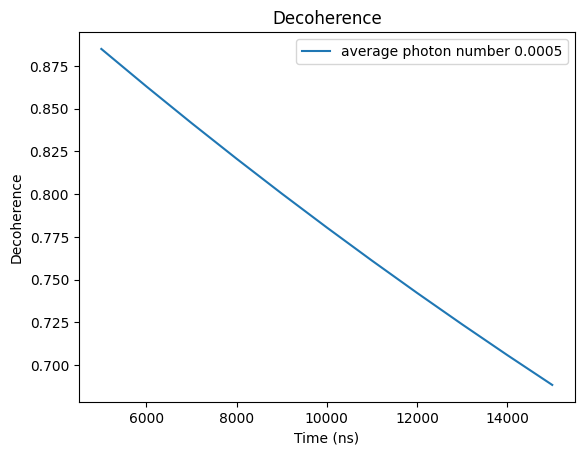

In [ ]:
# Plot Results

plt.plot(taulist, pluslist, label = 'average photon number 0.0005')

plt.legend(loc = 0)
plt.title('Decoherence')
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

0.0006283185307179586


Text(0, 0.5, 'Pure Dephasing Rate (kHz)')

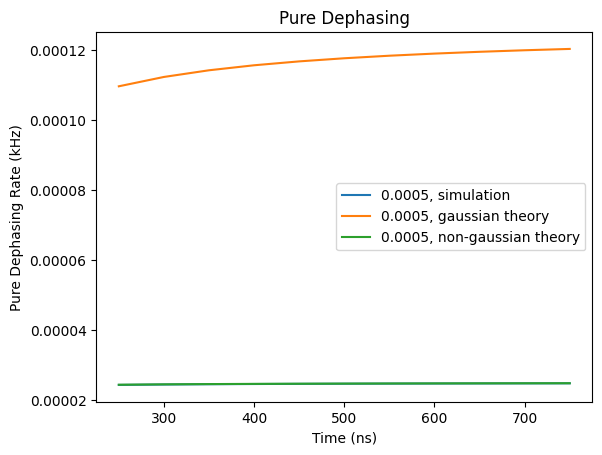

In [ ]:
n_th = 0.0005

delta_t = taulist/N_seq
gamma_phi = -np.log(pluslist)/(taulist) #- 0.5*kappa*g**2/detune**2


f_1 = 1+4*chi**2/kappa**2
f_2 = (np.cosh(kappa*delta_t) - np.cos(2*chi*delta_t))/(kappa*delta_t/2*np.sinh(kappa*delta_t)*f_1)

gamma_th_gaussian = (4*chi**2*n_th/kappa)*(1-np.tanh(kappa*delta_t/2)/(kappa*delta_t/2))
gamma_th_nongaussian = (4*chi**2*n_th/(kappa*f_1))*(1-f_2)

print(kappa*g**2/detune**2)

# Plot Results

plt.plot(delta_t, gamma_phi, label = '0.0005, simulation')
plt.plot(delta_t, gamma_th_gaussian, label = '0.0005, gaussian theory')
plt.plot(delta_t, gamma_th_nongaussian, label = '0.0005, non-gaussian theory')

plt.legend(loc = 0)
plt.title('Pure Dephasing')
plt.xlabel('Time (ns)')
plt.ylabel('Pure Dephasing Rate (kHz)')

0.0006283185307179586


Text(0, 0.5, 'Pure Dephasing Rate (kHz)')

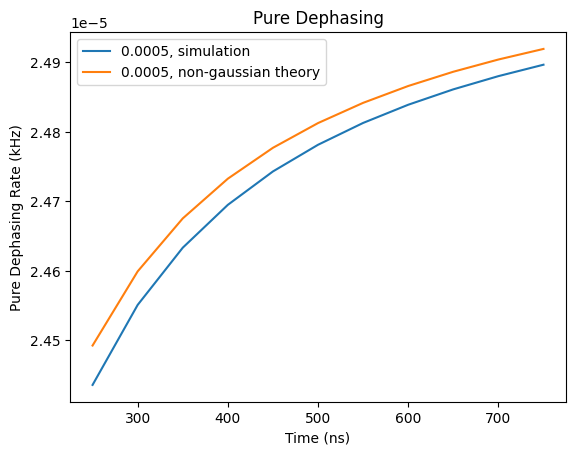

In [ ]:
n_th = 0.0005

delta_t = taulist/N_seq
gamma_phi = -np.log(pluslist)/(taulist) #- 0.5*kappa*g**2/detune**2


f_1 = 1+4*chi**2/kappa**2
f_2 = (np.cosh(kappa*delta_t) - np.cos(2*chi*delta_t))/(kappa*delta_t/2*np.sinh(kappa*delta_t)*f_1)

gamma_th_gaussian = (4*chi**2*n_th/kappa)*(1-np.tanh(kappa*delta_t/2)/(kappa*delta_t/2))
gamma_th_nongaussian = (4*chi**2*n_th/(kappa*f_1))*(1-f_2)

print(kappa*g**2/detune**2)

# Plot Results

plt.plot(delta_t, gamma_phi, label = '0.0005, simulation')
#plt.plot(delta_t, gamma_th_gaussian, label = '0.0005, gaussian theory')
plt.plot(delta_t, gamma_th_nongaussian, label = '0.0005, non-gaussian theory')

plt.legend(loc = 0)
plt.title('Pure Dephasing')
plt.xlabel('Time (ns)')
plt.ylabel('Pure Dephasing Rate (kHz)')

In [ ]:
A = 0.001 * 2 * np.pi
N_seq = 20

n_th = 0.005

zlist = []
pluslist = []

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = omega_r*number_composite + chi*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

# iterate for evolution time 100ns ~ 1000ns
for k in range(11):

  # Simulation
  tlist = np.linspace(0, 1000*(k+5), 10000*(k+5))

  result = mesolve(
    [H0, [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa*(n_th+1)) * tensor(qeye(2), a), np.sqrt(kappa*(n_th)) * tensor(qeye(2), a.dag())],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -20, 'T_end_q': 1000*(k+5)+20, 'N_seq': N_seq, 'Env': 0, 'Func': 0, 'A': A, 'T_srt_r': -100, 'T_end_r': 1500000},
    e_ops = op_list,
  )

  print(np.mean(result.expect[4]))

  z = result.expect[2]
  plus = 2*np.abs(result.expect[3])

  zlist.append(z[-1])
  pluslist.append(plus[-1])

zlist = np.array(zlist)
pluslist = np.array(pluslist)

0.0049840347562412676
0.004986695583451307
0.004988596185142609
0.004990021642331994
0.0049911303347657645
0.004992017290923259
0.004992742983786318
0.004993347728843631
0.00499385943691326
0.004994298044350605
0.00499467817118496


Text(0, 0.5, 'Decoherence')

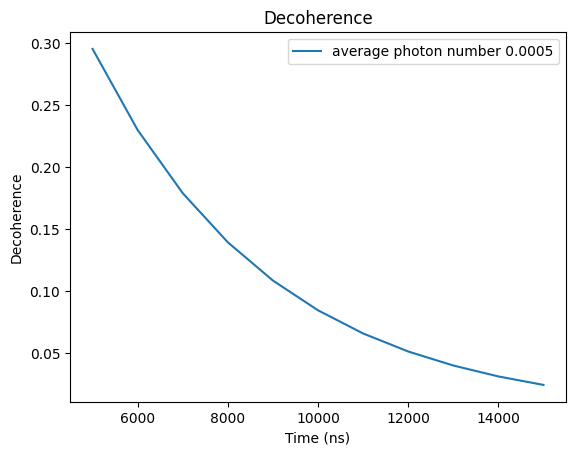

In [ ]:
# Plot Results

plt.plot(taulist, pluslist, label = 'average photon number 0.0005')

plt.legend(loc = 0)
plt.title('Decoherence')
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

0.0006283185307179586


Text(0, 0.5, 'Pure Dephasing Rate (kHz)')

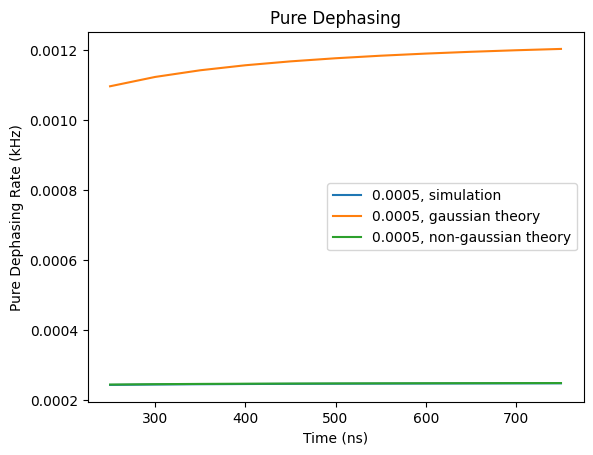

In [ ]:
n_th = 0.005

delta_t = taulist/N_seq
gamma_phi = -np.log(pluslist)/(taulist) #- 0.5*kappa*g**2/detune**2


f_1 = 1+4*chi**2/kappa**2
f_2 = (np.cosh(kappa*delta_t) - np.cos(2*chi*delta_t))/(kappa*delta_t/2*np.sinh(kappa*delta_t)*f_1)

gamma_th_gaussian = (4*chi**2*n_th/kappa)*(1-np.tanh(kappa*delta_t/2)/(kappa*delta_t/2))
gamma_th_nongaussian = (4*chi**2*n_th/(kappa*f_1))*(1-f_2)

print(kappa*g**2/detune**2)

# Plot Results

plt.plot(delta_t, gamma_phi, label = '0.005, simulation')
plt.plot(delta_t, gamma_th_gaussian, label = '0.005, gaussian theory')
plt.plot(delta_t, gamma_th_nongaussian, label = '0.005, non-gaussian theory')

plt.legend(loc = 0)
plt.title('Pure Dephasing')
plt.xlabel('Time (ns)')
plt.ylabel('Pure Dephasing Rate (kHz)')

0.0006283185307179586


Text(0, 0.5, 'Pure Dephasing Rate (kHz)')

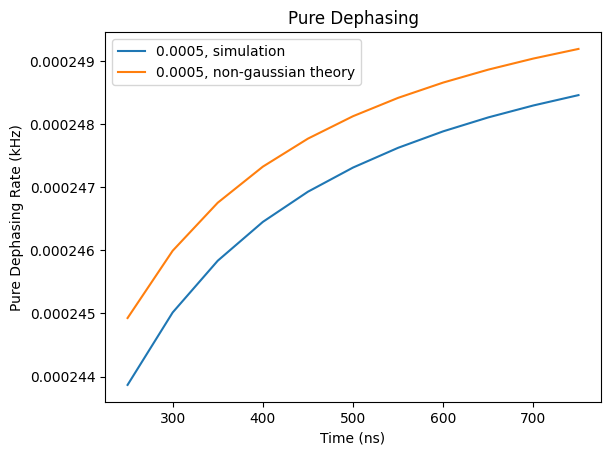

In [ ]:
n_th = 0.005

delta_t = taulist/N_seq
gamma_phi = -np.log(pluslist)/(taulist) #- 0.5*kappa*g**2/detune**2


f_1 = 1+4*chi**2/kappa**2
f_2 = (np.cosh(kappa*delta_t) - np.cos(2*chi*delta_t))/(kappa*delta_t/2*np.sinh(kappa*delta_t)*f_1)

gamma_th_gaussian = (4*chi**2*n_th/kappa)*(1-np.tanh(kappa*delta_t/2)/(kappa*delta_t/2))
gamma_th_nongaussian = (4*chi**2*n_th/(kappa*f_1))*(1-f_2)

print(kappa*g**2/detune**2)

# Plot Results

plt.plot(delta_t, gamma_phi, label = '0.0005, simulation')
#plt.plot(delta_t, gamma_th_gaussian, label = '0.0005, gaussian theory')
plt.plot(delta_t, gamma_th_nongaussian, label = '0.0005, non-gaussian theory')

plt.legend(loc = 0)
plt.title('Pure Dephasing')
plt.xlabel('Time (ns)')
plt.ylabel('Pure Dephasing Rate (kHz)')